In [1]:
import warnings
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Загружаємо необхідні дані, з поправкою на те що, ми прибрали всі ряди з NA значеннями.
#Таке рішення було прийняте з поправкуою на те, що NA значень в колонці make_id не повино бути, оскільки це foreign key.
#Окрім того, не логічно тримати в датасеті ряди з інформацією по викраденим автомобілям, коли ми навіть не знаємо що це за автомобіль
make_details = pd.read_csv('make_details.csv')
locations = pd.read_csv('locations.csv')
stolen_vehicles = pd.read_csv('stolen_vehicles.csv')
stolen_vehicles = stolen_vehicles.dropna()



###ТРЕТІЙ ПУНКТ

In [3]:
stolen_vehicles['date_stolen'] = pd.to_datetime(stolen_vehicles['date_stolen'])
stolen_vehicles['day_stolen'] = stolen_vehicles['date_stolen'].dt.day_name()
df = stolen_vehicles.groupby('day_stolen')['vehicle_id'].nunique().sort_values(ascending= False)
result = pd.concat([df.head(1), df.tail(1)], axis = 0)
result
###Як ми можемо бачити, найбільше автомобілів викрадається у понеділок, найменше у суботу

<ipython-input-3-c98618bfdd95>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stolen_vehicles['date_stolen'] = pd.to_datetime(stolen_vehicles['date_stolen'])


,vehicle_id
day_stolen,
Monday,759
Saturday,574


###ЧЕТВЕРТИЙ пункт

In [4]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


In [5]:
#Найкращим рішенням, на мою думку, буде надати можливість юзеру самому досліджувати статистику по викраденим типам автомобілів у розрізі регіонів
#Тому я створю інтерактивний графік у plotly, щоб динамічно оновлювати дані
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
df = stolen_vehicles.merge(locations, how= 'right', on = 'location_id')
df1 = df.groupby(['vehicle_type', 'region'])['vehicle_id'].nunique().sort_values(ascending=False).reset_index()
fig = go.Figure()
fig.add_trace(go.Bar(x = df1['vehicle_type'], y = df1['vehicle_id']))
fig.update_layout(
    title=dict(text = 'Total amount stolen by vehicle type', x = 0.5, xanchor = 'center'),
    xaxis_title='Vehicle Types',
    yaxis_title='Amount stolen'
)
app = dash.Dash()
app.layout = [dcc.Dropdown(id = 'region-dropdown',
                           options = df1['region'].unique(),
                           placeholder= 'Select the region',
                           value = 'Auckland'),
              dcc.Graph(id = 'bar-chart')]

@app.callback(
    Output('bar-chart', 'figure'),
    Input('region-dropdown', 'value')
)
def update_graph(reg):
  filt_df = df1[df1['region'] == reg]

  fig = go.Figure()
  fig.add_trace(go.Bar(x = filt_df['vehicle_type'], y = filt_df['vehicle_id']))
  fig.update_layout(
    title=dict(text = 'Total amount stolen by vehicle type', x = 0.5, xanchor = 'center'),
    xaxis_title='Vehicle Types',
    yaxis_title='Amount stolen'
  )
  return fig

app.run()
#Як ми можемо бачити, статистика по найбільш популярним типам автомобілів у розрізі регіонів відрізняється. Однак автомобілі типу Saloon та Stationwagon знаходяться у топі по викраденням у майже всіх регіонах

<ipython-input-5-f28ee73c4cc6>:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-5-f28ee73c4cc6>:6: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<IPython.core.display.Javascript object>

###П'ятий пункт

In [54]:
#Ми можемо використати показник R^2 для визначення зв'язку.
#Plotly дає нам змогу побудувати діаграму розсіювання, що дасть візуальне представлення зв'язку, та побудувати лінійну регресію за допомогою методу OLS, що дасть числове представлення сили зв'язку

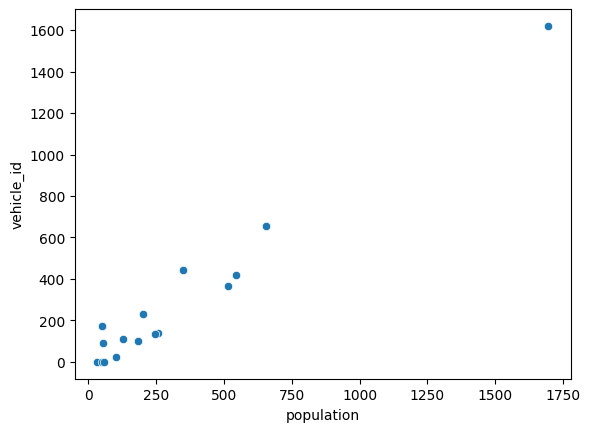

In [71]:
#Спочатку варто дослідити дані, які в нас є
df = stolen_vehicles.merge(locations, how = 'right', on = 'location_id')
df1 = df.groupby('population')['vehicle_id'].count().sort_values(ascending = False).reset_index()
df1['population'] = df1['population'].apply(lambda x: x.replace(',','')).astype(int)
df1['population'] = df1['population']/1000
sns.scatterplot(data = df1, x = 'population', y = 'vehicle_id')
plt.show()


In [70]:
##Бачимо очевидний викид, спробуємо його прибрати
import plotly.express as px
df1 = df1[df1['population'] != df1['population'].max()]
#Далі будуємо основний графік (для того щоб подивитися значення R^2 треба навести курсор на лінію)
fig = px.scatter(df1, x='population', y='vehicle_id', trendline="ols")
fig.update_xaxes(title = dict(text = 'Population in thousands'))
fig.show()
#Отримали високе значення R^2: 0,84, це підштовхує на думку що між популяцією та кількістю крадіжок є сильний зв'язок, однак варто зважати на те, що даних доволі мало

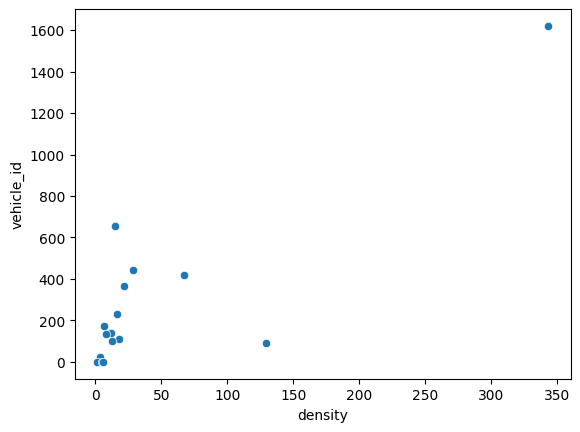

In [73]:
#Повторимо ті самі операції з щільністю населення
df2 = stolen_vehicles.merge(locations, how = 'right', on = 'location_id')
df3 = df.groupby('density')['vehicle_id'].count().sort_values(ascending = False).reset_index()
sns.scatterplot(data = df1, x = 'density', y = 'vehicle_id')
plt.show()

In [75]:
#Знову маємо викид, приберемо його та побудумо графік в plotly
df3 = df3[df3['density'] != df3['density'].max()]
fig = px.scatter(df3, x='density', y='vehicle_id', trendline="ols")
fig.show()
#Маємо значення R^2: 0.33. Взявши квадратий корінь отримуємо значення коефіцієнту регресії 0.57, що підштовхує до висновку, що міє щільністю населення та кількістю крадіжок є зв'язок, однак не такий сильний як з популяцією